In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [3]:
from sklearn.datasets import load_breast_cancer
from torchvision import datasets, transforms

In [4]:
train = datasets.MNIST('../data', train=True, transform=transforms.Compose([transforms.ToTensor()]))
test = datasets.MNIST('../data', train=False, transform=transforms.Compose([transforms.ToTensor()]))

In [5]:
X = train.data.float() / 255
y = train.targets
X = X.reshape(X.size(0), -1)
X.shape, y.shape

(torch.Size([60000, 784]), torch.Size([60000]))

In [6]:
input_size = X.size(-1)
output_size = int(max(y)) + 1

In [7]:
ratios = [0.8, 0.2]
train_cnt = int(X.size(0) * ratios[0])
valid_cnt = X.size(0) - train_cnt
test_cnt = len(test.data)
cnts = [train_cnt, valid_cnt]

In [8]:
indices = torch.randperm(X.size(0))
X = torch.index_select(X, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)
X = list(X.split(cnts, dim=0))
y = list(y.split(cnts, dim=0))
X += [(test.data.float() / 255).reshape(test_cnt, -1)]
y += [test.targets]

for X_i, y_i in zip(X, y):
    print(X_i.size(), y_i.size())

torch.Size([48000, 784]) torch.Size([48000])
torch.Size([12000, 784]) torch.Size([12000])
torch.Size([10000, 784]) torch.Size([10000])


In [9]:
class Block(nn.Module):
    def __init__(self, input_size, output_size, use_batch_norm=True, dropout_p=0.4):
        self.input_size = input_size
        self.output_size = output_size
        self.use_batch_norm = use_batch_norm
        self.dropout_p = dropout_p

        super().__init__()

        def get_regularizer(use_batch_norm, size):
            return nn.BatchNorm1d(size) if use_batch_norm else nn.Dropout(dropout_p)
        
        self.block = nn.Sequential(nn.Linear(input_size, output_size), nn.LeakyReLU(), get_regularizer(use_batch_norm, output_size))

    def forward(self, X):
        y = self.block(X)
        return y

In [10]:
class MyModel(nn.Module):
    def __init__(self, input_size, output_size, use_batch_norm=True, dropout_p=0.4):
        super().__init__()

        self.layers = nn.Sequential(
            Block(input_size, 500, use_batch_norm, dropout_p),
            Block(500, 400, use_batch_norm, dropout_p),
            Block(400, 300, use_batch_norm, dropout_p),
            Block(300, 200, use_batch_norm, dropout_p),
            Block(200, 100, use_batch_norm, dropout_p),
            Block(100, 50, use_batch_norm, dropout_p),
            nn.Linear(50, output_size),
            nn.LogSoftmax(dim=-1)
        )

    def forward(self, X):
        y = self.layers(X)
        return y

In [11]:
model = MyModel(input_size, output_size, use_batch_norm=True)
print(model)

MyModel(
  (layers): Sequential(
    (0): Block(
      (block): Sequential(
        (0): Linear(in_features=784, out_features=500, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Block(
      (block): Sequential(
        (0): Linear(in_features=500, out_features=400, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): Block(
      (block): Sequential(
        (0): Linear(in_features=400, out_features=300, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): Block(
      (block): Sequential(
        (0): Linear(in_features=300, out_features=200, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(200, e

In [12]:
optimizer = optim.Adam(model.parameters())
crit = nn.NLLLoss()

In [13]:
n_epochs = 1000
batch_size = 256
print_interval = 10
early_stop = 50

In [14]:
lowest_loss = np.inf
best_model = None
lowest_epoch = np.inf

In [15]:
train_history, valid_history = ([], [])

for i in range(n_epochs):
    model.train()

    indices = torch.randperm(X[0].size(0))
    X_ = torch.index_select(X[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)
    X_ = X_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)

    train_loss, valid_loss = 0, 0
    y_hat = []

    for X_i, y_i in zip(X_, y_):
        y_hat_i = model(X_i)
        loss = crit(y_hat_i, y_i.squeeze())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += float(loss)
    
    train_loss = train_loss / len(X_)

    model.eval()
    with torch.no_grad():
        X_ = X[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)

        valid_loss = 0

        for X_i, y_i in zip(X_, y_):
            y_hat_i = model(X_i)
            loss = crit(y_hat_i, y_i.squeeze())

            valid_loss += float(loss)
            y_hat += [y_hat_i]

    valid_loss = valid_loss / len(X_)

    train_history += [train_loss]
    valid_history += [valid_loss]

    if (i + 1) % print_interval == 0:
        print(f'Epoch {i + 1}: train loss={train_loss:.4e}, valid loss={valid_loss:.4e}, lowest loss={lowest_loss:.4e}')
    
    if valid_loss < lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        best_model = deepcopy(model.state_dict())
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print(f'There is no improvement during last {early_stop} epochs.')
            break

print(f'The best validation loss from epoch {lowest_epoch + 1}: {lowest_loss:.4e}')

model.load_state_dict(best_model)

Epoch 10: train loss=2.0845e-02, valid loss=8.5828e-02, lowest loss=9.0045e-02
Epoch 20: train loss=1.2315e-02, valid loss=8.0765e-02, lowest loss=8.5828e-02
Epoch 30: train loss=7.9470e-03, valid loss=9.3864e-02, lowest loss=8.0765e-02
Epoch 40: train loss=5.1939e-03, valid loss=1.0013e-01, lowest loss=8.0765e-02
Epoch 50: train loss=4.3804e-03, valid loss=9.4916e-02, lowest loss=8.0765e-02
Epoch 60: train loss=4.5392e-03, valid loss=1.0192e-01, lowest loss=8.0765e-02
Epoch 70: train loss=3.7009e-03, valid loss=1.0052e-01, lowest loss=8.0765e-02
There is no improvement during last 50 epochs.
The best validation loss from epoch 20: 8.0765e-02


<All keys matched successfully>

In [16]:
print(f'The best validation loss from epoch {lowest_epoch + 1}: {lowest_loss:.4e}')

The best validation loss from epoch 20: 8.0765e-02


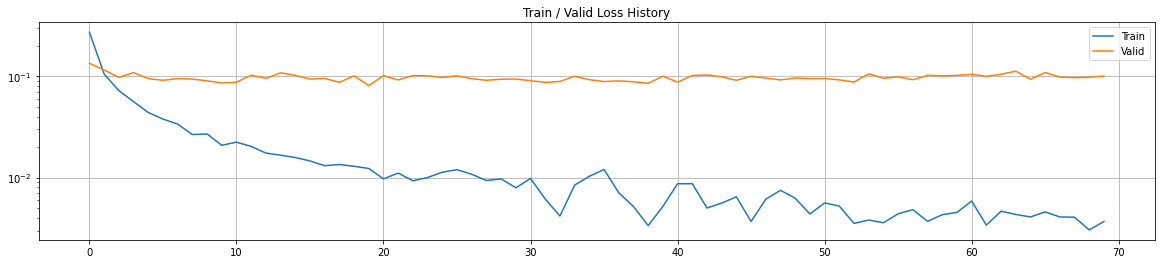

In [17]:
plot_from = 0

fig, ax = plt.subplots(1, 1, figsize=(20, 4))
plt.title('Train / Valid Loss History')
ax.plot(range(plot_from, len(train_history)), train_history[plot_from:],
         range(plot_from, len(valid_history)), valid_history[plot_from:])
plt.grid(True)
plt.yscale('log')
plt.legend(['Train', 'Valid'])
plt.show()

In [18]:
test_loss = 0
y_hat = []

model.eval()
with torch.no_grad():
    X_ = X[2].split(batch_size, dim=0)
    y_ = y[2].split(batch_size, dim=0)

    for X_i, y_i in zip(X_, y_):
        y_hat_i = model(X_i)
        loss = crit(y_hat_i, y_i.squeeze())

        test_loss += float(loss)
        y_hat += [y_hat_i]

test_loss = test_loss / len(X_)
y_hat = torch.concat(y_hat, dim=0)

sorted_history = sorted(zip(train_history, valid_history), key=lambda x: x[1])

print(f'Train loss: {sorted_history[0][0]:.4e}')
print(f'Valid loss: {sorted_history[0][1]:.4e}')
print(f'Test loss: {test_loss:.4e}')

Train loss: 1.2315e-02
Valid loss: 8.0765e-02
Test loss: 8.0600e-02


In [19]:
correct_cnt = (y[2].squeeze() == torch.argmax(y_hat, dim=-1)).sum()
total_cnt = int(y[2].size(0))
print(f'Test Accuracy: {correct_cnt / total_cnt:.4f}')

Test Accuracy: 0.9801


In [20]:
pd.DataFrame(confusion_matrix(y[2], torch.argmax(y_hat, dim=-1)), index=[f'True_{i}' for i in range(10)], columns=[f'Pred_{i}' for i in range(10)])

,Pred_0,Pred_1,Pred_2,Pred_3,Pred_4,Pred_5,Pred_6,Pred_7,Pred_8,Pred_9
True_0,970,1,0,0,0,2,3,1,2,1
True_1,0,1127,2,1,0,1,1,1,2,0
True_2,3,0,1012,4,1,0,0,6,6,0
True_3,0,0,3,989,0,5,0,4,7,2
True_4,1,1,3,1,963,0,4,2,1,6
True_5,2,0,0,12,0,873,2,0,2,1
True_6,4,3,0,1,4,8,936,0,2,0
True_7,1,4,8,0,3,0,1,1006,1,4
True_8,0,0,3,5,3,5,0,2,946,10
True_9,0,1,1,3,14,4,0,7,0,979
